In [3]:
import pandas as pd
import os
import openai
import json
from dotenv import load_dotenv

load_dotenv()

script_dir = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

counsel_path = os.path.join(script_dir, "data", "cleaned_counselchat.csv")
train_path = os.path.join(script_dir, "data", "tmp_recipe_finetune_training.jsonl")
val_path = os.path.join(script_dir, "data", "tmp_recipe_finetune_validation.jsonl")

MAX_SIZE = 700
SYS_MSG = """You are Regina, a helpful counselor with a lot of empathy.
You talk to people who need psychological support and try to alleviate
their pain by giving advice without making judgments."""

# Get test data

In [49]:
df = pd.read_csv(counsel_path)
df = df.drop_duplicates(subset="questionText")
result = []

for path in [train_path, val_path]:
    with open(path) as file:
        for line in file:
            json_dict = json.loads(line)["messages"]
            question = json_dict[1]["content"]
            answer = json_dict[2]["content"]
            result.append({"questionText": question, "clean_answer": answer})

In [53]:
full_df = pd.read_csv(counsel_path)
full_df = full_df.drop_duplicates(subset="questionText")
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 944 entries, 0 to 2623
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   questionText  944 non-null    object
 1   clean_answer  944 non-null    object
dtypes: object(2)
memory usage: 22.1+ KB


In [110]:
df_test = full_df[~full_df["questionText"].isin(df["questionText"])].sample(50)
df_test.to_csv(os.path.join(script_dir, "data", "test.csv"), index=False)
df_test.head()

,questionText,clean_answer
793,"I'm in my early 20s. I’ve been married once, a...",Sounds as though you're taking the blame for t...
2503,"After receiving counseling, we have been told ...",I never heard of a marriage mediator before.Si...
1503,There's this boy who asked me out awhile ago. ...,Since you've decided to be with the boy who al...
1273,We make love once per month. Is it normal?,"To begin with, what's normal for one couple is..."
1669,I have dog obsession disorder and I am having ...,"Hey, dogs are cool. They adore pleasing humans..."


# Save answers from GPT-3.5-turbo and Fine-tuned model

In [71]:
def format_data(row):
    messages = list()

    messages.append({
        "role": "system",
        "content": SYS_MSG
    })

    messages.append({
        "role": "user",
        "content": row["questionText"]
    })
    return messages

messages = df_test.apply(format_data, axis=1)

In [74]:
chatgpt_answer = list()
for message in messages:
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=message,
        max_tokens=300
    )
    question = message[1]["content"]
    answer = response["choices"][0]["message"]["content"]
    chatgpt_answer.append({"question": question, "answer": answer})
    

In [76]:
gpt_df = pd.DataFrame(chatgpt_answer).sort_values(by="question").reset_index(drop=True)
gpt_df.to_csv(os.path.join(save_path, "chatgpt-3.5-turbo_test.csv"), index=False)
gpt_df.head()

,question,answer
0,"After receiving counseling, we have been told ...",It's great to hear that you and your husband h...
1,"Ever since I was little, I loved the idea of l...",I can understand how frustrating and dishearte...
2,He's lied about his past/present situations. S...,I understand how difficult it can be to naviga...
3,How do I cope with losing my mom?,I'm really sorry to hear about the loss of you...
4,How do I deal with OCD?,I'm here to offer support and guidance as you ...


In [169]:
import time

fine_tuned_model_id = "ft:gpt-3.5-turbo-0613:dq-data:counselor-test2:7y0ExFEB"
finetuned_answer = list()
for message in messages:
    for delay_secs in (2*x**2 for x in range(1, 6)):
        try:
            response = openai.ChatCompletion.create(
                model=fine_tuned_model_id,
                messages=message,
                max_tokens=300
            )
            question = message[1]["content"]
            answer = response["choices"][0]["message"]["content"]
            finetuned_answer.append({"question": question, "answer": answer})
            break
        except openai.OpenAIError:
            print("sleeping: ", delay_secs)
            time.sleep(delay_secs)

finetuned_df = pd.DataFrame(finetuned_answer).sort_values(by="question").reset_index(drop=True)
finetuned_df.to_csv(os.path.join(save_path, "fine-tuned_test.csv"), index=False)
finetuned_df.head()

sleeping:  2
sleeping:  8
sleeping:  18
sleeping:  2
sleeping:  2


,question,answer
0,"After receiving counseling, we have been told ...","If the only issue is the one you describe, I a..."
1,"Ever since I was little, I loved the idea of l...",Would you benefit from having a relationship?I...
2,He's lied about his past/present situations. S...,Trust and intimacy are closely related and go ...
3,How do I cope with losing my mom?,The loss of a parent is so tough. If you get t...
4,How do I deal with OCD?,Here are a few general tips for dealing with O...


# Word cloud

In [6]:
from PIL import Image
from wordcloud import WordCloud
import numpy as np

assets_dir = os.path.join(script_dir, "assets")

gpt_text = "\n".join(gpt_df["answer"])
fine_tuned_text = "\n".join(finetuned_df["answer"])

mask = np.array(Image.open(os.path.join(assets_dir, "brain_mask.png")))

In [9]:
stopwords = list()
with open(os.path.join(script_dir, "stopwords.txt"), "r") as file:
    for line in file:
        stopwords.append(line.strip())

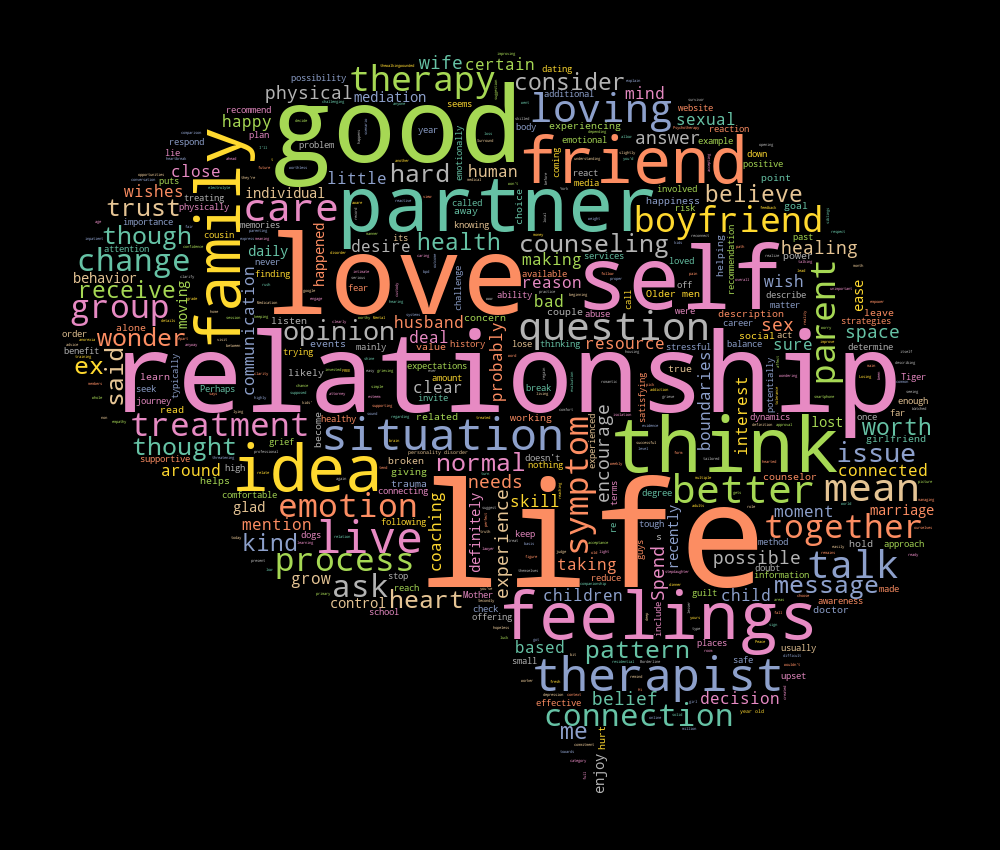

In [8]:
wc = WordCloud(background_color="black", max_words=500, mask=mask,
               stopwords=stopwords, colormap="Set2")

wc.generate(fine_tuned_text)
img_path = os.path.join(assets_dir, "brain.png")
wc.to_file(img_path)

im = Image.open(img_path)
display(im)